<a href="https://colab.research.google.com/github/ArtuomMerkulov/ArtuomMerkulov/blob/main/%D0%9F%D0%A0%D0%95%D0%94%D0%A1%D0%9A%D0%90%D0%97%D0%90%D0%9D%D0%98%D0%95%20%D0%90%D0%9A%D0%A6%D0%98%D0%99%20TESLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание стоимости акции Tesla

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import to_categorical 
import numpy as np 
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
step_in_the_last = 20   # По скольки шагам в прошлое определяем тренд     ##20,16,16,4
n_steps = 20            # Серию из скольки дней анализируем         ##44,42,48,6
forvard_lag = 1         # Предсказание какого бара в будущем делаем       ##1
analyze_period = 1000    # Сколько баров в прошлое берем для тренировки модели (чтобы ихбежать тренировки на другой динамике рынка) #3000,2000,1000

In [ ]:
!unzip '/content/drive/MyDrive/Numpy/Цена акций Tesla.zip'

Archive:  /content/drive/MyDrive/Numpy/Цена акций Tesla.zip
  inflating: TSLA.csv                


In [ ]:
data = pd.read_csv('/content/TSLA.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-03,1.789333,1.800000,1.726667,1.774667,1.774667,19245000
1,2011-01-04,1.777333,1.796667,1.734667,1.778000,1.778000,17811000
2,2011-01-05,1.765333,1.793333,1.746000,1.788667,1.788667,21700500
3,2011-01-06,1.788667,1.866667,1.787333,1.858667,1.858667,30918000
4,2011-01-07,1.866667,1.905333,1.860000,1.882667,1.882667,33718500
...,...,...,...,...,...,...,...
3019,2022-12-30,119.949997,124.480003,119.750000,123.180000,123.180000,157304500
3020,2023-01-03,118.470001,118.800003,104.639999,108.099998,108.099998,231402800
3021,2023-01-04,109.110001,114.589996,107.519997,113.639999,113.639999,180389000
3022,2023-01-05,110.510002,111.750000,107.160004,110.339996,110.339996,157986300


In [ ]:
del data['Adj Close'] 
del data['Volume'] 
data

,Date,Open,High,Low,Close
0,2011-01-03,1.789333,1.800000,1.726667,1.774667
1,2011-01-04,1.777333,1.796667,1.734667,1.778000
2,2011-01-05,1.765333,1.793333,1.746000,1.788667
3,2011-01-06,1.788667,1.866667,1.787333,1.858667
4,2011-01-07,1.866667,1.905333,1.860000,1.882667
...,...,...,...,...,...
3019,2022-12-30,119.949997,124.480003,119.750000,123.180000
3020,2023-01-03,118.470001,118.800003,104.639999,108.099998
3021,2023-01-04,109.110001,114.589996,107.519997,113.639999
3022,2023-01-05,110.510002,111.750000,107.160004,110.339996


In [ ]:
#data = pd.read_csv('/content/SBER_MIN60.txt', sep="\t", header=None)
data.columns=['Date', 'Open', 'High', 'Low', 'Close']

mask = (data['Date'] >= '2011-01-03') & (data['Date'] <= '2023-01-06')
data = data[mask]
data

,Date,Open,High,Low,Close
0,2011-01-03,1.789333,1.800000,1.726667,1.774667
1,2011-01-04,1.777333,1.796667,1.734667,1.778000
2,2011-01-05,1.765333,1.793333,1.746000,1.788667
3,2011-01-06,1.788667,1.866667,1.787333,1.858667
4,2011-01-07,1.866667,1.905333,1.860000,1.882667
...,...,...,...,...,...
3019,2022-12-30,119.949997,124.480003,119.750000,123.180000
3020,2023-01-03,118.470001,118.800003,104.639999,108.099998
3021,2023-01-04,109.110001,114.589996,107.519997,113.639999
3022,2023-01-05,110.510002,111.750000,107.160004,110.339996


In [ ]:
df_data = data.drop(data.columns[[1, 2, 3]], axis='columns') 
del data['Date']

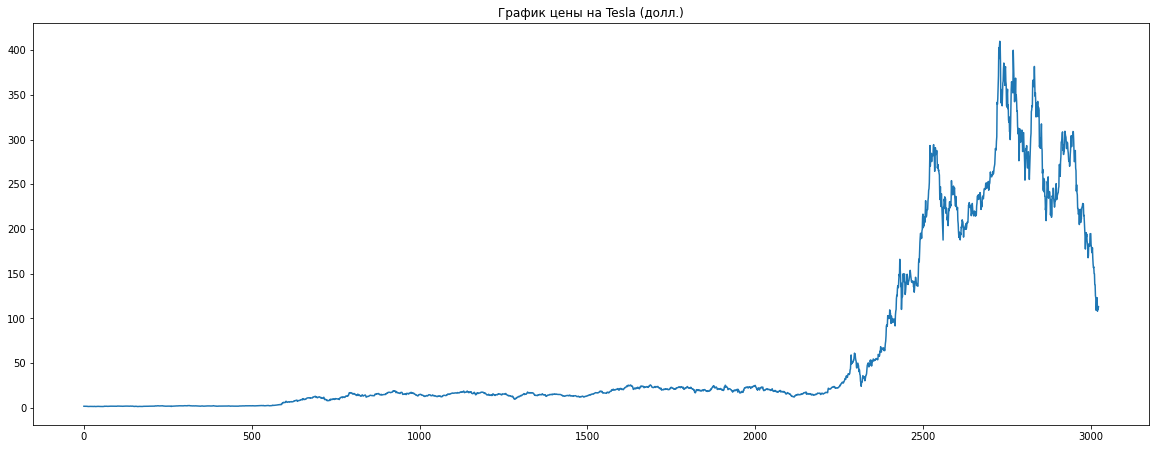

In [ ]:
plt.figure(figsize=(20,10))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
data['Close'].plot(ax = ax0)
plt.title('График цены на Tesla (долл.)')
plt.show()

In [ ]:
# считаем относительную доходность единицах на step_in_the_last шагов назад
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  data[indicator_name] = data['Close'].pct_change(i) # относительная доходность единицах

print(data.shape)
data

(3024, 24)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,...,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14,Close_chng_15,Close_chng_16,Close_chng_17,Close_chng_18,Close_chng_19,Close_chng_20
0,1.789333,1.800000,1.726667,1.774667,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.777333,1.796667,1.734667,1.778000,0.001878,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.765333,1.793333,1.746000,1.788667,0.005999,0.007889,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.788667,1.866667,1.787333,1.858667,0.039135,0.045370,0.047333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.866667,1.905333,1.860000,1.882667,0.012912,0.052553,0.058868,0.060856,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,119.949997,124.480003,119.750000,123.180000,0.011164,0.092893,0.129056,0.000244,-0.017312,-0.104601,...,-0.214413,-0.234669,-0.265999,-0.312036,-0.289783,-0.292232,-0.314982,-0.324856,-0.367854,-0.367334
3020,118.470001,118.800003,104.639999,108.099998,-0.122422,-0.112625,-0.040901,-0.009166,-0.122209,-0.137615,...,-0.314391,-0.310587,-0.328363,-0.355858,-0.396258,-0.376730,-0.378878,-0.398843,-0.407509,-0.445243
3021,109.110001,114.589996,107.519997,113.639999,0.051249,-0.077448,-0.067148,0.008251,0.041613,-0.077223,...,-0.243560,-0.279254,-0.275255,-0.293942,-0.322846,-0.365317,-0.344788,-0.347047,-0.368035,-0.377144
3022,110.510002,111.750000,107.160004,110.339996,-0.029039,0.020722,-0.104238,-0.094237,-0.021027,0.011366,...,-0.263762,-0.265526,-0.300184,-0.296301,-0.314445,-0.342510,-0.383748,-0.363815,-0.366008,-0.386386


In [ ]:
data.fillna(0, inplace=True)
data

,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,...,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14,Close_chng_15,Close_chng_16,Close_chng_17,Close_chng_18,Close_chng_19,Close_chng_20
0,1.789333,1.800000,1.726667,1.774667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.777333,1.796667,1.734667,1.778000,0.001878,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.765333,1.793333,1.746000,1.788667,0.005999,0.007889,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.788667,1.866667,1.787333,1.858667,0.039135,0.045370,0.047333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.866667,1.905333,1.860000,1.882667,0.012912,0.052553,0.058868,0.060856,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,119.949997,124.480003,119.750000,123.180000,0.011164,0.092893,0.129056,0.000244,-0.017312,-0.104601,...,-0.214413,-0.234669,-0.265999,-0.312036,-0.289783,-0.292232,-0.314982,-0.324856,-0.367854,-0.367334
3020,118.470001,118.800003,104.639999,108.099998,-0.122422,-0.112625,-0.040901,-0.009166,-0.122209,-0.137615,...,-0.314391,-0.310587,-0.328363,-0.355858,-0.396258,-0.376730,-0.378878,-0.398843,-0.407509,-0.445243
3021,109.110001,114.589996,107.519997,113.639999,0.051249,-0.077448,-0.067148,0.008251,0.041613,-0.077223,...,-0.243560,-0.279254,-0.275255,-0.293942,-0.322846,-0.365317,-0.344788,-0.347047,-0.368035,-0.377144
3022,110.510002,111.750000,107.160004,110.339996,-0.029039,0.020722,-0.104238,-0.094237,-0.021027,0.011366,...,-0.263762,-0.265526,-0.300184,-0.296301,-0.314445,-0.342510,-0.383748,-0.363815,-0.366008,-0.386386


In [ ]:
data = data.dropna() 
print(data.shape)
data

(3024, 24)


,Open,High,Low,Close,Close_chng_1,Close_chng_2,Close_chng_3,Close_chng_4,Close_chng_5,Close_chng_6,...,Close_chng_11,Close_chng_12,Close_chng_13,Close_chng_14,Close_chng_15,Close_chng_16,Close_chng_17,Close_chng_18,Close_chng_19,Close_chng_20
0,1.789333,1.800000,1.726667,1.774667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.777333,1.796667,1.734667,1.778000,0.001878,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.765333,1.793333,1.746000,1.788667,0.005999,0.007889,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.788667,1.866667,1.787333,1.858667,0.039135,0.045370,0.047333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.866667,1.905333,1.860000,1.882667,0.012912,0.052553,0.058868,0.060856,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,119.949997,124.480003,119.750000,123.180000,0.011164,0.092893,0.129056,0.000244,-0.017312,-0.104601,...,-0.214413,-0.234669,-0.265999,-0.312036,-0.289783,-0.292232,-0.314982,-0.324856,-0.367854,-0.367334
3020,118.470001,118.800003,104.639999,108.099998,-0.122422,-0.112625,-0.040901,-0.009166,-0.122209,-0.137615,...,-0.314391,-0.310587,-0.328363,-0.355858,-0.396258,-0.376730,-0.378878,-0.398843,-0.407509,-0.445243
3021,109.110001,114.589996,107.519997,113.639999,0.051249,-0.077448,-0.067148,0.008251,0.041613,-0.077223,...,-0.243560,-0.279254,-0.275255,-0.293942,-0.322846,-0.365317,-0.344788,-0.347047,-0.368035,-0.377144
3022,110.510002,111.750000,107.160004,110.339996,-0.029039,0.020722,-0.104238,-0.094237,-0.021027,0.011366,...,-0.263762,-0.265526,-0.300184,-0.296301,-0.314445,-0.342510,-0.383748,-0.363815,-0.366008,-0.386386


In [ ]:
# Добавил разметку направления тренда
for i in range(1, step_in_the_last + 1):
  indicator_name = 'Close_chng_%d' % (i)
  indicator_name_new = 'Y_%d' % (i)
  data[indicator_name_new] = 0
  data.loc[data[indicator_name] > 0 , indicator_name_new] = 1

for i in range(1, step_in_the_last):
  indicator_name = 'Close_chng_%d' % (i)
  del data[indicator_name]

del data['Open'], data['High'], data['Low']

print(data.shape)
data

(3024, 22)


,Close,Close_chng_20,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,...,Y_11,Y_12,Y_13,Y_14,Y_15,Y_16,Y_17,Y_18,Y_19,Y_20
0,1.774667,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.778000,0.000000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.788667,0.000000,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.858667,0.000000,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.882667,0.000000,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,123.180000,-0.367334,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3020,108.099998,-0.445243,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3021,113.639999,-0.377144,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3022,110.339996,-0.386386,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


**Формируем y_train**

In [ ]:
indicator_name = 'Y_%d' % (step_in_the_last)
data_Y = data[indicator_name]
data_Y

0       0
1       0
2       0
3       0
4       0
       ..
3019    0
3020    0
3021    0
3022    0
3023    0
Name: Y_20, Length: 3024, dtype: int64

In [ ]:
categorical_labels = to_categorical(data_Y, num_classes = 2)
print(len(categorical_labels))
categorical_labels[:5]

3024


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

**Делим на обучающую и проверочную выборки**

In [ ]:
data = data.values
print(data.shape, type(data))

(3024, 22) <class 'numpy.ndarray'>


In [ ]:
n_train = 505
xTrain = data[:-n_train-n_steps]
xTest = data[-n_train:]
yTrain = categorical_labels[:-n_train-n_steps]
yTest = categorical_labels[-n_train:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (2499, 22) 	yTrain: (2499, 2) 
xTest:   (505, 22) 	yTest:  (505, 2)


3004

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest

(2499, 22) (505, 22) <class 'numpy.ndarray'>


array([[ 8.58270906,  0.7352374 ,  0.9688716 , ...,  0.85405607,
         0.85615986,  0.85615986],
       [ 9.32285194,  1.18288806,  0.9688716 , ...,  0.85405607,
         0.85615986,  0.85615986],
       [10.11130211,  2.3360359 ,  0.9688716 , ...,  0.85405607,
         0.85615986,  0.85615986],
       ...,
       [ 3.46776332, -2.46303395,  0.9688716 , ..., -1.17088332,
        -1.16800617, -1.16800617],
       [ 3.34576166, -2.51628059, -1.03212851, ..., -1.17088332,
        -1.16800617, -1.16800617],
       [ 3.44632059, -2.30882977,  0.9688716 , ..., -1.17088332,
        -1.16800617, -1.16800617]])

**Ручной TimeSeries**

In [ ]:
def split_sequence(sequence, Y, n_steps, forvard_lag):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # проверяем, чтобы не выйти за пределы массива
      break 
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return np.array(X), np.array(y)

In [ ]:
#for i in [forvard_lag, 0, 0]:
for i in [forvard_lag]:
  xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag=i)

  print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
  print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTrain и yTrain:	 (2479, 20, 22) (2479, 2)


In [ ]:
"""
# Число баров в прошлом для анализа - место для эксперимента от 0 до 90
"""
#for i in [forvard_lag, 0, 0]:
for i in [forvard_lag]:
  # Формируем выборки для обучения нейросети
  xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag=i)

  print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
  print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)


Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTest и yTest:	 (485, 20, 22) (485, 2)


## Создание нейронной сети

In [ ]:
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)


Epoch 1/100
78/78 [==============================] - 10s 9ms/step - loss: 0.4638 - accuracy: 0.8225 - val_loss: 0.4014 - val_accuracy: 0.8186
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 0.2506 - accuracy: 0.8983 - val_loss: 0.3329 - val_accuracy: 0.8557
Epoch 3/100
78/78 [==============================] - 0s 5ms/step - loss: 0.2048 - accuracy: 0.9197 - val_loss: 0.2499 - val_accuracy: 0.8887
Epoch 4/100
78/78 [==============================] - 0s 5ms/step - loss: 0.1825 - accuracy: 0.9266 - val_loss: 0.2469 - val_accuracy: 0.9052
Epoch 5/100
78/78 [==============================] - 1s 7ms/step - loss: 0.1678 - accuracy: 0.9338 - val_loss: 0.2228 - val_accuracy: 0.9196
Epoch 6/100
78/78 [==============================] - 1s 8ms/step - loss: 0.1550 - accuracy: 0.9403 - val_loss: 0.2108 - val_accuracy: 0.9258
Epoch 7/100
78/78 [==============================] - 1s 8ms/step - loss: 0.1434 - accuracy: 0.9484 - val_loss: 0.1941 - val_accuracy: 0.9340
Epoch 8/100


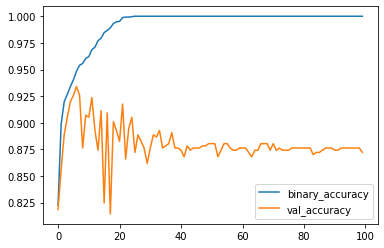

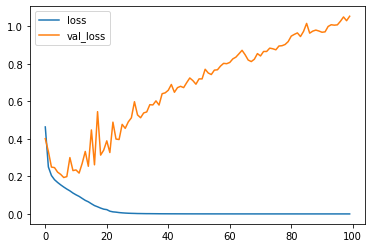

In [ ]:
#xTrain , yTrain = X, y # если не используется TimeSeries
model.compile(optimizer=Adam(learning_rate = 5e-05),
              loss='binary_crossentropy',
              metrics=['accuracy']) 

# fit model
history = model.fit(xTrain, yTrain, epochs=100, verbose = 1,
                    validation_data=(xTest, yTest))

plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# От себя добавил цикл для распознавания всех тестовых вариантов и вывода класса
x_test = xTest[-100:]
y_test_org = yTest[-100:]
true_answer = 0
for i in range(len(x_test)):   # Выбираю пример
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) 
  prediction = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)

  if prediction == np.argmax(y_test_org[i]):
    true_answer+=1
  
  print('Index:', i, '\tPrediction:', prediction, 'Real:', np.argmax(y_test_org[i]),
        '\t====>', y_test_org[i])

print('Правильных ответов:', true_answer)
print('Ошибочных ответов:', 100- true_answer)

1/1 [==============================] - 0s 137ms/step
Index: 0 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 15ms/step
Index: 1 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 14ms/step
Index: 2 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 16ms/step
Index: 3 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 13ms/step
Index: 4 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 15ms/step
Index: 5 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 14ms/step
Index: 6 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 17ms/step
Index: 7 	Prediction: 1 Real: 1 	====> [0. 1.]
1/1 [==============================] - 0s 22ms/step
Index: 8 	Prediction: 0 Real: 0 	====> [1. 0.]
1/1 [==============================] - 0s 30ms/step
Index: 9 	Prediction: 1 Real: 0 	====> [1. 0.]
1/1 [====

In [ ]:
83/100 * 100

83.0